In [5]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
is_out_exist = os.path.exists('output')
if not is_out_exist:
    # Create a new directory because it does not exist
    os.makedirs('output')
    print("The new directory is created!")
target_image = '.\\cat.jpg'
img_cat = cv2.imread(target_image, cv2.IMREAD_COLOR)
target_image = '.\\Barbara.jpg'
img_Barbara = cv2.imread(target_image, cv2.IMREAD_COLOR)
image_lib = {'cat': img_cat, 'bar': img_Barbara}

In [6]:
def show_image(img, name):
    cv2.imshow(name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
def MSE(img1, img2):
    img1 = np.array(img1, dtype=np.float64)
    img2 = np.array(img2, dtype=np.float64)
    return np.mean((img1 - img2) ** 2)
def myRGB(img, sub_sampling=False):
    return RGB2YCbCr(img, sub_sampling)
def mineRGB(img):
    return YCbCr2RGB(img)
def draw(testList, title):
    plt.scatter(*zip(*testList))
    plt.ylim(ymin=20, ymax=35)
    plt.xlim(xmin=0, xmax=65)
    plt.xlabel('compress rate')
    plt.ylabel('psnr')
    plt.title(title)
    plt.savefig('output\\' + title + '.png')
    plt.show()
def RGB2YCbCr(img, sub_sampling=False):
    if sub_sampling:
        img_y_cb_cr = np.zeros(img.shape, dtype = int)   
        y = (0.257 * img[:,:,0]) + (0.564 * img[:,:,1]) + (0.098 * img[:,:,2]) + 16
        u = -(0.148 * img[:,:,0]) - (0.291 * img[:,:,1]) + (0.439 * img[:,:,2]) + 128
        v = (0.439 * img[:,:,0]) - (0.368 * img[:,:,1]) - (0.071 * img[:,:,2]) + 128
        u[1::2,1::2] = u[::2, ::2]
        v[1::2,1::2] = v[::2, ::2]
        #print(y.shape, u.shape, v.shape)
        img_y_cb_cr = np.dstack((y, u, v))
        #print(img_y_cb_cr.shape)
    else:
        img_y_cb_cr = np.zeros(img.shape, dtype = int)   
        img_y_cb_cr[:,:, 0] = (0.257 * img[:,:,0]) + (0.564 * img[:,:,1]) + (0.098 * img[:,:,2]) + 16
        img_y_cb_cr[:,:, 1] = -(0.148 * img[:,:,0]) - (0.291 * img[:,:,1]) + (0.439 * img[:,:,2]) + 128
        img_y_cb_cr[:,:, 2] = (0.439 * img[:,:,0]) - (0.368 * img[:,:,1]) - (0.071 * img[:,:,2]) + 128
        #print(img_y_cb_cr.shape)
    return img_y_cb_cr
def YCbCr2RGB(img):
    img_rgb = np.zeros(img.shape , dtype = int)
    img_rgb[:,:, 0] =  1.164 * (img[:,:,0] - 16) + 0 * (img[:,:,1] - 128) + 1.596 * (img[:,:,2] - 128)
    img_rgb[:,:, 1] =  1.164 * (img[:,:,0] - 16) - 0.382 * (img[:,:,1] - 128) -0.813 * (img[:,:,2] - 128)
    img_rgb[:,:, 2] =  1.164 * (img[:,:,0] - 16) + 2.017 * (img[:,:,1] - 128) + 0 * (img[:,:,2] - 128)
    img_rgb[img_rgb > 255] = 255
    img_rgb[img_rgb < 0 ]= 0
    return img_rgb.astype(np.uint8)
def generate_DCT_matrix():
    res = np.zeros((8,8))
    for i in range(8):
        for j in range(8):
            if i == 0:
                res[i,j] = 1/np.sqrt(8)
            else:
                res[i,j] = np.sqrt(2/8) * np.cos(((2*j+1)*i*np.pi)/16)
    return res
def DCT(block, T):
    res = np.zeros((8,8))
    res = np.dot(np.dot(T, block), T.T)
    return res
def iDCT(block, T):
    res = np.zeros((8,8))
    res = np.dot(np.dot(T.T, block), T)
    return res
def uniform_quantization(block, n, m, channel):
    res = np.zeros((n,n))
    quantized_table = np.array(  [[ 8,  6,  6,  7,  6,  5,  8,  7],
                                  [ 7,  7,  9,  9,  8, 10, 12, 20],
                                  [13, 12, 11, 11, 12, 25, 18, 19],
                                  [15, 20, 29, 26, 31, 30, 29, 26],
                                  [28, 28, 32, 36, 46, 39, 32, 34],
                                  [44, 35, 28, 28, 40, 55, 41, 44],
                                  [48, 49, 52, 52, 52, 31, 39, 57],
                                  [61, 56, 50, 60, 46, 51, 52, 50]])
    luminance_table = np.array(  [[16, 11, 10, 16, 24, 40, 51, 61],
                                  [12, 12, 14, 19, 26, 58, 60, 55],
                                  [14, 13, 16, 24, 40, 57, 69, 56],
                                  [14, 17, 22, 29, 51, 87, 80, 62],
                                  [18, 22, 37, 56, 68,109,103, 77],
                                  [24, 36, 55, 64, 81,104,113, 92],
                                  [49, 64, 78, 87,103,121,120,101],
                                  [72, 92 ,95, 98,112,100,103, 99]])
    chrominance_table = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                                  [18, 21, 26, 66, 99, 99, 99, 99],
                                  [24, 26, 56, 99, 99, 99, 99, 99],
                                  [47, 66, 99, 99, 99, 99, 99, 99],
                                  [99, 99, 99, 99, 99, 99, 99, 99],
                                  [99, 99, 99, 99, 99, 99, 99, 99],
                                  [99, 99, 99, 99, 99, 99, 99, 99],
                                  [99, 99, 99, 99, 99, 99, 99, 99]])
    for i in range(n):
        for j in range(n):
            if channel==0:
                res[i,j] = block[i,j] / luminance_table[i,j]
            else:
                res[i,j] = block[i,j] / chrominance_table[i,j]
    big = np.max(res)
    small = np.min(res)
    total_interval = big - small
    step = 2**m
    interval_unit = total_interval / step
    ladder = np.zeros(step)
    for i in range(step):
        ladder[i] = small + i * interval_unit
    ladder[np.argmin(abs(ladder))] = 0
    map_on_ladder = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            map_on_ladder[i,j] = np.argmin(np.abs(res[i,j] - ladder))
    return map_on_ladder, ladder
def uniform_dequantization(block, n, m, ladder, channel):
    res = np.zeros((n,n))
    quantized_table = np.array(  [[ 8,  6,  6,  7,  6,  5,  8,  7],
                                  [ 7,  7,  9,  9,  8, 10, 12, 20],
                                  [13, 12, 11, 11, 12, 25, 18, 19],
                                  [15, 20, 29, 26, 31, 30, 29, 26],
                                  [28, 28, 32, 36, 46, 39, 32, 34],
                                  [44, 35, 28, 28, 40, 55, 41, 44],
                                  [48, 49, 52, 52, 52, 31, 39, 57],
                                  [61, 56, 50, 60, 46, 51, 52, 50]])
    luminance_table = np.array(  [[16, 11, 10, 16, 24, 40, 51, 61],
                                  [12, 12, 14, 19, 26, 58, 60, 55],
                                  [14, 13, 16, 24, 40, 57, 69, 56],
                                  [14, 17, 22, 29, 51, 87, 80, 62],
                                  [18, 22, 37, 56, 68,109,103, 77],
                                  [24, 36, 55, 64, 81,104,113, 92],
                                  [49, 64, 78, 87,103,121,120,101],
                                  [72, 92 ,95, 98,112,100,103, 99]])
    chrominance_table = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                                  [18, 21, 26, 66, 99, 99, 99, 99],
                                  [24, 26, 56, 99, 99, 99, 99, 99],
                                  [47, 66, 99, 99, 99, 99, 99, 99],
                                  [99, 99, 99, 99, 99, 99, 99, 99],
                                  [99, 99, 99, 99, 99, 99, 99, 99],
                                  [99, 99, 99, 99, 99, 99, 99, 99],
                                  [99, 99, 99, 99, 99, 99, 99, 99]])
    for i in range(n):
        for j in range(n):
            block[i,j] = ladder[int(block[i,j])]
    for i in range(n):
        for j in range(n):
            if channel==0:
                res[i,j] = np.round(block[i,j] * luminance_table[i,j])
            else:
                res[i,j] = np.round(block[i,j] * chrominance_table[i,j])
    return res
def DCT_image_compression(img, n, m, sub_sampling=False):
    #divide the image into 8x8 blocks
    T = generate_DCT_matrix()
    res = np.zeros(img.shape, dtype = int)
    for i in range(0, img.shape[0], 8):
        for j in range(0, img.shape[1], 8):
            for c in range(3):
                unit_block = img[i:i+8, j:j+8,c].copy()
                shifted_unit_block = unit_block - 128
                my_dct = DCT(shifted_unit_block, T)
                #keep only lower-frequency
                coef = my_dct[:n, :n]
                map_on_ladder, ladder= uniform_quantization  (coef,           n, m,                channel=c)
                dequantized_coef     = uniform_dequantization(map_on_ladder,  n, m, ladder=ladder, channel=c)
                unit_block = np.zeros(unit_block.shape, dtype = int)
                unit_block[:n, :n] = dequantized_coef
                my_idct = iDCT(unit_block, T)
                my_idct = my_idct + 128
                res[i:i+8, j:j+8, c] = my_idct 
    compress_rate = ((img.shape[0]/8*img.shape[1]/8)*(n**2)*3*m)/((img.shape[0]/8*img.shape[1]/8)*(8**2)*3*8)
    if sub_sampling:
        compress_rate = compress_rate * (6/12)
    sigma = MSE(img, res)
    snr = 10*np.log10(np.max(img)**2/sigma)
    return res, 1/compress_rate, snr

# a

cat_n2m4_a, compress rate: 32.00, snr: 25.89
cat_n2m8_a, compress rate: 16.00, snr: 26.23
cat_n4m4_a, compress rate: 8.00, snr: 30.69
cat_n4m8_a, compress rate: 4.00, snr: 32.43


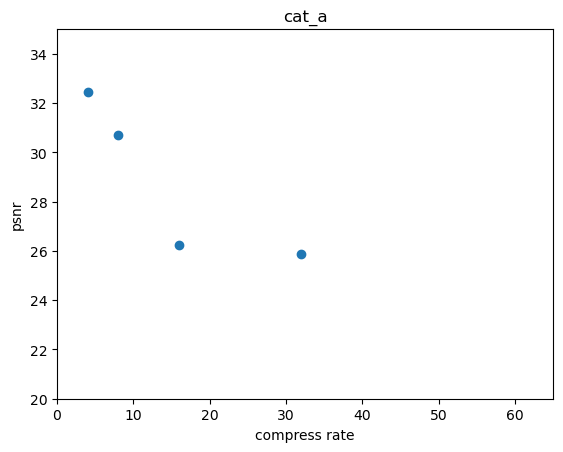

bar_n2m4_a, compress rate: 32.00, snr: 29.92
bar_n2m8_a, compress rate: 16.00, snr: 30.18
bar_n4m4_a, compress rate: 8.00, snr: 32.81
bar_n4m8_a, compress rate: 4.00, snr: 33.82


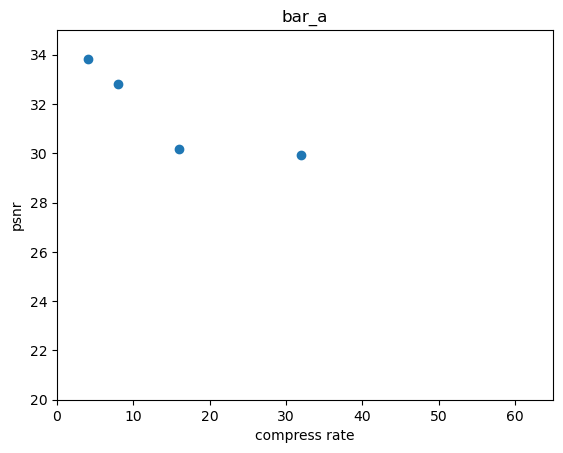

In [7]:
for name in ['cat', 'bar']:
    testList = []
    for n in [2,4]:
        for m in [4,8]:
            process_target = image_lib[name].copy()
            yiq_img = myRGB(process_target)
            go_to_yiq, compress_rate, snr = DCT_image_compression(yiq_img, n, m)
            res = mineRGB(go_to_yiq)
            idx = 'n' + str(n) + 'm' + str(m)
            cv2.imwrite('.\\output\\'+ name + '_' + idx + '_a.png', res)
            print(name + '_' + idx + '_a'+', compress rate: {:.2f}, snr: {:.2f}'.format(compress_rate, snr))
            testList.append([compress_rate, snr])
    draw(testList, name+ '_a')

# b

cat_n2m4_b, compress rate: 64.00, snr: 25.88
cat_n2m8_b, compress rate: 32.00, snr: 26.24
cat_n4m4_b, compress rate: 16.00, snr: 30.65
cat_n4m8_b, compress rate: 8.00, snr: 32.42


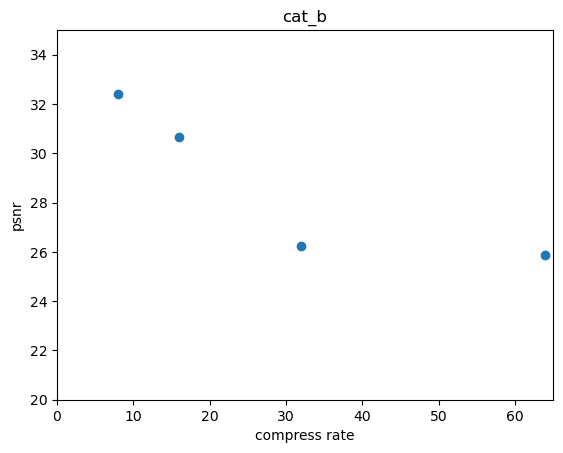

bar_n2m4_b, compress rate: 64.00, snr: 29.93
bar_n2m8_b, compress rate: 32.00, snr: 30.19
bar_n4m4_b, compress rate: 16.00, snr: 32.80
bar_n4m8_b, compress rate: 8.00, snr: 33.80


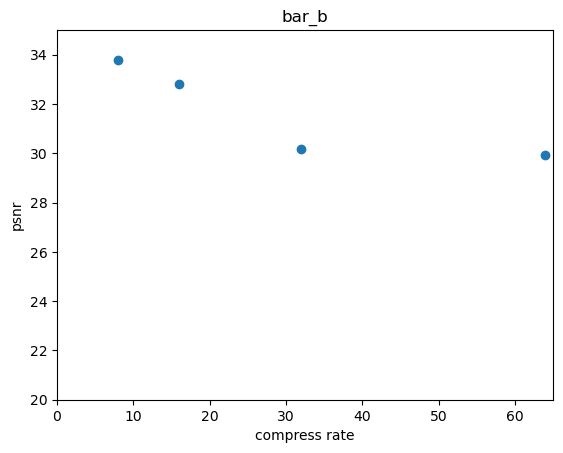

In [8]:
for name in ['cat', 'bar']:
    testList = []
    for n in [2,4]:
        for m in [4,8]:
            process_target = image_lib[name].copy()
            yiq_img                       = RGB2YCbCr            (process_target, sub_sampling=True)
            go_to_yiq, compress_rate, snr = DCT_image_compression(yiq_img, n, m,  sub_sampling=True)
            res                           = YCbCr2RGB            (go_to_yiq)
            idx = 'n' + str(n) + 'm' + str(m)
            cv2.imwrite('.\\output\\'+ name + '_' + idx + '_b.png', res)
            print(name + '_' + idx + '_b'+', compress rate: {:.2f}, snr: {:.2f}'.format(compress_rate, snr))
            testList.append([compress_rate, snr])
    draw(testList, name+ '_b')